### Frequency Band Selection

Because humans speak in a very narrow frequency band, let's evaluate our models given only that specific band of frequencies. First, we'll need to determine which bands work best for our data.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json
import audioread
from tqdm import tqdm
import warnings
import glob


import librosa
from pydub import AudioSegment
import wave
import audioop
from scipy.stats import skew
from sklearn.preprocessing import normalize

import torch

### Determining Frequency Band

To determine which frequency band we want to isolate, let's iterate over our human audio files and output the most common frequencies. We'll use the crowdsourced Mozilla dataset because it will contain the largest range of values due to the nature of the recordings.

### Human

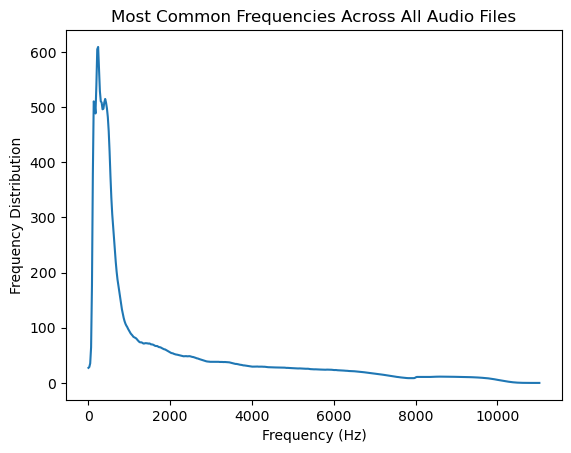

In [16]:
audio_folder = 'datasets/Audio/Mozilla_delta(wav)/'

n_fft = 1024
hop_length = n_fft // 2

# Define the frequency range
frequencies = np.linspace(0, sr/2, n_fft//2 + 1)

total_distribution = np.zeros(shape=(frequencies.shape[0],))

for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):
        # Load the audio file
        audio_path = os.path.join(audio_folder, filename)
        y, sr = librosa.load(audio_path)

        # Compute the spectrogram
        S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann'))

        # Compute the frequency distribution and add it to the running total
        distribution = np.sum(S, axis=1)
        total_distribution += distribution

# Normalize the total distribution by the number of audio files
total_distribution /= len(os.listdir(audio_folder))

# Plot the resulting frequency distribution
plt.plot(frequencies, total_distribution)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Distribution')
plt.title('Most Common Frequencies Across All Audio Files')
plt.show()

In [17]:
total_distribution_hum = total_distribution

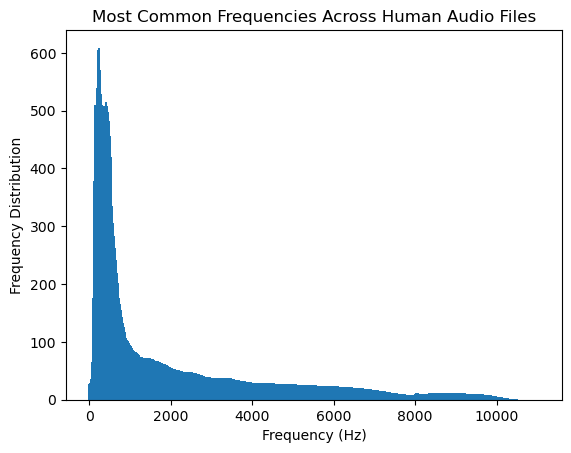

In [33]:
plt.bar(frequencies, total_distribution_hum, width=50)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Distribution')
plt.title('Most Common Frequencies Across Human Audio Files')
plt.show()

In [19]:
total_distribution

array([2.73053827e+01, 2.88796108e+01, 3.55261019e+01, 6.46014584e+01,
       1.76715762e+02, 3.78091013e+02, 5.10209056e+02, 5.04816367e+02,
       4.88327707e+02, 5.39429412e+02, 6.04637899e+02, 6.08906761e+02,
       5.69632480e+02, 5.28569631e+02, 5.10505636e+02, 5.08000907e+02,
       4.95855449e+02, 4.96860825e+02, 5.08328358e+02, 5.14660115e+02,
       5.07739413e+02, 4.97402100e+02, 4.81731181e+02, 4.56485691e+02,
       4.19262736e+02, 3.74268604e+02, 3.35440329e+02, 3.05876413e+02,
       2.84005614e+02, 2.63289461e+02, 2.41064873e+02, 2.19260505e+02,
       2.01600378e+02, 1.87317938e+02, 1.75902044e+02, 1.65876359e+02,
       1.54611726e+02, 1.43087526e+02, 1.33433806e+02, 1.25761855e+02,
       1.17885287e+02, 1.11918485e+02, 1.07288556e+02, 1.03935033e+02,
       1.01378298e+02, 9.79531303e+01, 9.50600800e+01, 9.22911040e+01,
       8.95106419e+01, 8.76512586e+01, 8.58769680e+01, 8.36228414e+01,
       8.26633983e+01, 8.17929268e+01, 8.08984792e+01, 7.92026216e+01,
      

### Synthetic

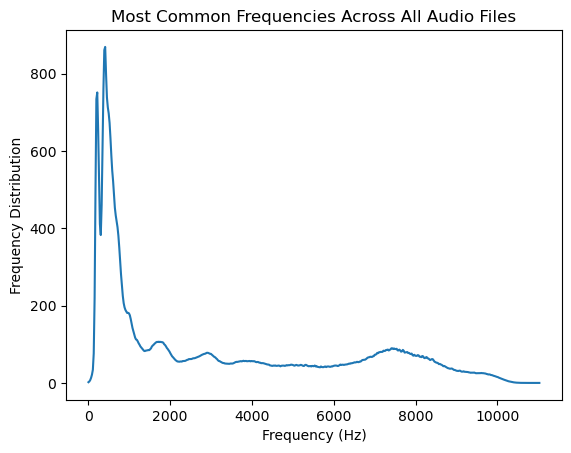

In [24]:
audio_folder = 'datasets/Audio/somos/'

n_fft = 1024
hop_length = n_fft // 2

# Define the frequency range
frequencies = np.linspace(0, sr/2, n_fft//2 + 1)

total_distribution = np.zeros(shape=(frequencies.shape[0],))

for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):
        # Load the audio file
        audio_path = os.path.join(audio_folder, filename)
        y, sr = librosa.load(audio_path)

        # Compute the spectrogram
        S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann'))

        # Compute the frequency distribution and add it to the running total
        distribution = np.sum(S, axis=1)
        total_distribution += distribution

# Normalize the total distribution by the number of audio files
total_distribution /= len(os.listdir(audio_folder))

# Plot the resulting frequency distribution
plt.plot(frequencies, total_distribution)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Distribution')
plt.title('Most Common Frequencies Across All Audio Files')
plt.show()

In [25]:
total_distribution_syn = total_distribution

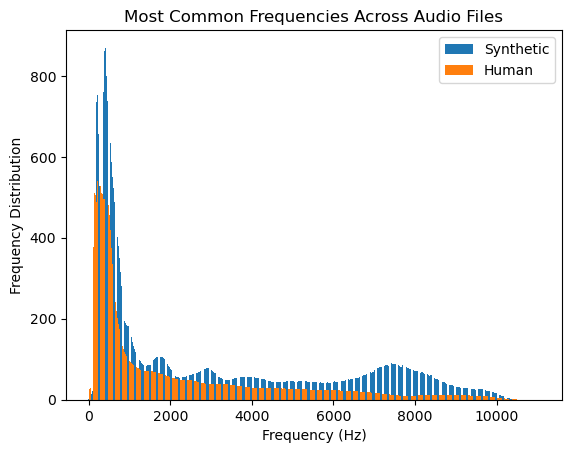

In [37]:
bar_width = 15
x1 = frequencies
x2 = [i + bar_width for i in x1]

# Plot the two bars side-by-side
plt.bar(x1, total_distribution_syn, width=bar_width, label='Synthetic')
plt.bar(x2, total_distribution_hum, width=bar_width, label='Human')

# Add labels and a title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Distribution')
plt.title('Most Common Frequencies Across Audio Files')
plt.legend()

# Display the plot
plt.show()

The comparison of frequency distributions between the two datasets is revealing. Frequencies above 500 Hz are far less common in our human audio than they are with the synthetic audio. Additionally, the synthetic audio has far more instances of high frequencies (<2000 Hz). Where the human audio gradually descends to near 0 occurances between 2000 and 10000 Hz, the synthetic audio has spikes in instances that are considerable and should be looked into.

Mean frequency: 5512.5
Standard deviation: 3188.853400635123
Cutoff frequency: 7106.926700317561


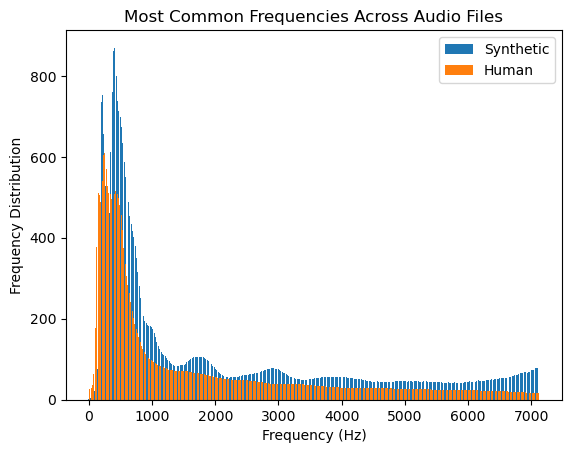

In [41]:
mean_frequency = np.mean(frequencies)
std_frequency = np.std(frequencies)

# Define a threshold as a multiple of the standard deviation
threshold = .5 * std_frequency

# Define a cutoff frequency based on the threshold
cutoff_frequency = mean_frequency + threshold

# Print the mean, standard deviation, and cutoff frequency
print("Mean frequency:", mean_frequency)
print("Standard deviation:", std_frequency)
print("Cutoff frequency:", cutoff_frequency)

# Plot the two bars side-by-side with a cutoff
bar_width = 15
x1 = frequencies[frequencies <= cutoff_frequency]
x2 = [i + bar_width for i in x1]

plt.bar(x1, total_distribution_syn[frequencies <= cutoff_frequency], width=bar_width, label='Synthetic')
plt.bar(x2, total_distribution_hum[frequencies <= cutoff_frequency], width=bar_width, label='Human')

# Add labels and a title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency Distribution')
plt.title('Most Common Frequencies Across Audio Files')
plt.legend()

# Display the plot
plt.show()

Seeing this, let's select the low frequency band which represents between 80 and 255 Hz. This frequency band is particularly relevant for voice recognition tasks, as it contains many of the fundamental frequencies of human speech.

In fact, research has shown that the most important information for speech recognition is contained in the lower frequency bands, with frequencies below 500 Hz being particularly critical for recognizing vowels and other speech sounds. This is because the lower frequency components of speech carry information about the pitch, loudness, and timing of the speech signal, which are important cues for speech recognition.

In addition to speech recognition, the low frequency band may be relevant for other audio analysis tasks that involve identifying or processing low-frequency sounds, such as bass guitar, kick drum, or other instruments that produce sounds in this frequency range. It may also be useful for noise reduction or filtering tasks, as many types of noise (such as background hum or electrical interference) are often concentrated in the lower frequency bands.

The low frequency band is a valuable and important part of the frequency spectrum for many types of audio analysis, particularly for voice recognition and other tasks that involve processing human speech.